In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 01:09:17 2016

@author: stephen
"""

from tensorflow import keras
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

np.random.seed(813306)


def build_resnet(input_shape, n_feature_maps, nb_classes):
    print("build conv_x")
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding="same")(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1, padding="same")(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    print("build conv_x")
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps * 2, 8, 1, padding="same")(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps * 2, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps * 2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps * 2, 1, 1, padding="same")(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    print("build conv_x")
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps * 2, 8, 1, padding="same")(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps * 2, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps * 2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps * 2, 1, 1, padding="same")(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation="softmax")(full)
    print("        -- model was built.")
    return x, out


def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:, 0]
    X = data[:, 1:]
    return X, Y


epochs = 400

flist = ["../../datasets/GunPoint/GunPoint"]

for each in flist:
    fname = each
    x_train, y_train = readucr(fname + "_TRAIN.txt")
    x_test, y_test = readucr(fname + "_TEST.txt")
    nb_classes = len(np.unique(y_test))
    # batch_size = int(min(x_train.shape[0] / 10, 16))
    batch_size = int(x_train.shape[0])

    y_train = (
        (y_train - y_train.min()) / (y_train.max() - y_train.min()) * (nb_classes - 1)
    )
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min()) * (nb_classes - 1)

    Y_train = keras.utils.to_categorical(y_train, nb_classes)
    Y_test = keras.utils.to_categorical(y_test, nb_classes)

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean) / (x_train_std)

    x_test = (x_test - x_train_mean) / (x_train_std)
    x_train = x_train.reshape(
        x_train.shape
        + (
            1,
            1,
        )
    )
    x_test = x_test.reshape(
        x_test.shape
        + (
            1,
            1,
        )
    )

    x, y = build_resnet(x_train.shape[1:], 64, nb_classes)
    model = keras.models.Model(inputs=x, outputs=y)
    optimizer = keras.optimizers.Adam()
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=50, min_lr=0.0001
    )
    es = EarlyStopping(monitor="val_loss", verbose=1, min_delta=1e-6, patience=200)

    hist = model.fit(
        x_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, Y_test),
        callbacks=[reduce_lr, es],
    )
    

build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Epoch 1/400
1/1 [==============================] - 15s 15s/step - loss: 0.7140 - accuracy: 0.6400 - val_loss: 0.6939 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 2/400
1/1 [==============================] - 6s 6s/step - loss: 0.5968 - accuracy: 0.7000 - val_loss: 0.6934 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/400
1/1 [==============================] - 6s 6s/step - loss: 1.4470 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/400
1/1 [==============================] - 5s 5s/step - loss: 0.4819 - accuracy: 0.6600 - val_loss: 0.6931 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 5/400
1/1 [==============================] - 6s 6s/step - loss: 0.5365 - accuracy: 0.7600 - val_loss: 0.6929 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 6/400
1/1 [=========

1/1 [==============================] - 3s 3s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7161 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 54/400
1/1 [==============================] - 3s 3s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7182 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 55/400
1/1 [==============================] - 3s 3s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7203 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 56/400
1/1 [==============================] - 3s 3s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7225 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 57/400
1/1 [==============================] - 3s 3s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 58/400
1/1 [==============================] - 3s 3s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7273 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 59/400
1/1 [==============================] - 3s 3s/step - loss: 0.0012 - accuracy: 1.0000 - va

Epoch 106/400
1/1 [==============================] - 3s 3s/step - loss: 4.3829e-04 - accuracy: 1.0000 - val_loss: 0.9671 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 107/400
1/1 [==============================] - 3s 3s/step - loss: 4.3264e-04 - accuracy: 1.0000 - val_loss: 0.9747 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 108/400
1/1 [==============================] - 3s 3s/step - loss: 4.2714e-04 - accuracy: 1.0000 - val_loss: 0.9826 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 109/400
1/1 [==============================] - 4s 4s/step - loss: 4.2172e-04 - accuracy: 1.0000 - val_loss: 0.9905 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 110/400
1/1 [==============================] - 4s 4s/step - loss: 4.1637e-04 - accuracy: 1.0000 - val_loss: 0.9985 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 111/400
1/1 [==============================] - 4s 4s/step - loss: 4.1118e-04 - accuracy: 1.0000 - val_loss: 1.0067 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 112/400
1/1 [==============================] - 3s 3s

1/1 [==============================] - 4s 4s/step - loss: 2.5365e-04 - accuracy: 1.0000 - val_loss: 1.5050 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 159/400
1/1 [==============================] - 4s 4s/step - loss: 2.5143e-04 - accuracy: 1.0000 - val_loss: 1.5176 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 160/400
1/1 [==============================] - 4s 4s/step - loss: 2.4924e-04 - accuracy: 1.0000 - val_loss: 1.5304 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 161/400
1/1 [==============================] - 4s 4s/step - loss: 2.4711e-04 - accuracy: 1.0000 - val_loss: 1.5432 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 162/400
1/1 [==============================] - 3s 3s/step - loss: 2.4498e-04 - accuracy: 1.0000 - val_loss: 1.5562 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 163/400
1/1 [==============================] - 4s 4s/step - loss: 2.4289e-04 - accuracy: 1.0000 - val_loss: 1.5692 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 164/400
1/1 [==============================] - 3s 3s/step - loss: 

1/1 [==============================] - 3s 3s/step - loss: 1.6847e-04 - accuracy: 1.0000 - val_loss: 2.2662 - val_accuracy: 0.5067 - lr: 5.0000e-04
Epoch 211/400
1/1 [==============================] - 3s 3s/step - loss: 1.6787e-04 - accuracy: 1.0000 - val_loss: 2.2807 - val_accuracy: 0.5067 - lr: 5.0000e-04
Epoch 212/400
1/1 [==============================] - 3s 3s/step - loss: 1.6730e-04 - accuracy: 1.0000 - val_loss: 2.2952 - val_accuracy: 0.5067 - lr: 5.0000e-04
Epoch 212: early stopping


In [3]:
# evaluate the model
_, train_acc = model.evaluate(x_train, Y_train)
_, test_acc = model.evaluate(x_test, Y_test)

5/5 [==============================] - 1s 116ms/step - loss: 2.2952 - accuracy: 0.5067


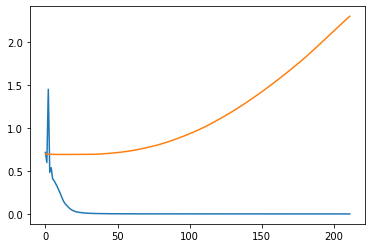

In [6]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

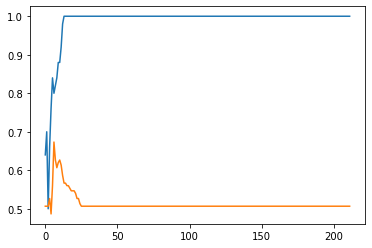

In [7]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.show()